<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/2021notebooks/2021_1113PyTorch_official_reinforcement_q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash

# install required system dependencies
apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

In [ ]:
!pip install pyvirtualdisplay

In [1]:
import pyvirtualdisplay

_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

process exited early. stderr:b"_XSERVTransmkdir: ERROR: euid != 0,directory /tmp/.X11-unix will not be created.\n_XSERVTransSocketUNIXCreateListener: mkdir(/tmp/.X11-unix) failed, errno = 2\n_XSERVTransMakeAllCOTSServerListeners: failed to create listener for local\n(EE) \nFatal server error:\n(EE) Cannot establish any listening sockets - Make sure an X server isn't already running(EE) \n"
start failed 1
process exited early. stderr:b"_XSERVTransmkdir: ERROR: euid != 0,directory /tmp/.X11-unix will not be created.\n_XSERVTransSocketUNIXCreateListener: mkdir(/tmp/.X11-unix) failed, errno = 2\n_XSERVTransMakeAllCOTSServerListeners: failed to create listener for local\n(EE) \nFatal server error:\n(EE) Cannot establish any listening sockets - Make sure an X server isn't already running(EE) \n"
start failed 2
process exited early. stderr:b"_XSERVTransmkdir: ERROR: euid != 0,directory /tmp/.X11-unix will not be created.\n_XSERVTransSocketUNIXCreateListener: mkdir(/tmp/.X11-unix) failed, errn

XStartError: No success after 10 retries. Last stderr: b"_XSERVTransmkdir: ERROR: euid != 0,directory /tmp/.X11-unix will not be created.\n_XSERVTransSocketUNIXCreateListener: mkdir(/tmp/.X11-unix) failed, errno = 2\n_XSERVTransMakeAllCOTSServerListeners: failed to create listener for local\n(EE) \nFatal server error:\n(EE) Cannot establish any listening sockets - Make sure an X server isn't already running(EE) \n"

In [13]:
%matplotlib inline

# 強化学習(DQN)チュートリアル
<!-- # Reinforcement Learning (DQN) Tutorial -->

**著者**: [Adam Paszke](https://github.com/apaszke)

このチュートリアルでは PyTorch を使って [OpenAI Gym](https://gym.openai.com/) の CartPole-v0 課題で Deep Q Learning (DQN) エージェントを訓練する方法を紹介する。
<!-- This tutorial shows how to use PyTorch to train a Deep Q Learning (DQN) agent on the CartPole-v0 task from the [OpenAI Gym](https://gym.openai.com/)-->

**課題**
<!-- **Task** -->

エージェントは，カートに取り付けられたポールが直立するように，カートを左右に動かすという 2 つの行動のどちらかを決定しなければならない。
様々なアルゴリズムと視覚化による公式リーダーボードは [Gym website](https://gym.openai.com/envs/CartPole-v0) で見ることができる。
<!-- The agent has to decide between two actions - moving the cart left or right - so that the pole attached to it stays upright. 
You can find an official leaderboard with various algorithms and visualizations at the [Gym website](https://gym.openai.com/envs/CartPole-v0) -->

<center>
<img src="https://pytorch.org/tutorials/_images/cartpole.gif" width="33%" alt="cartpole">
</center>

エージェントが環境の現在の状態を観察し，行動を選択すると，環境は新しい状態に **遷移**し，また行動の結果を示す報酬を返す。
この課題では，報酬はタイムステップごとに +1 され，ポールが倒れすぎるか，カートが中心から 2.4 単位以上離れると，環境は終了する。
これは，より良い成績をとるシナリオは，より長い時間実行され，より大きなリターンを蓄積することを意味する。
<!-- As the agent observes the current state of the environment and chooses an action, the environment *transitions* to a new state, and also returns a reward that indicates the consequences of the action. 
In this task, rewards are +1 for every incremental timestep and the environment terminates if the pole falls over too far or the cart moves more then 2.4 units away from center. 
This means better performing scenarios will run for longer duration, accumulating larger return.-->

CartPole 課題は，エージェントへの入力が環境の状態 (位置，速度など) を表す 4 つの実数値であるように設計されている。
しかし，ニューラルネットワークは純粋にシーンを見るだけで課題を解くことができるので，カートを中心とした画面のパッチを入力として使用することにする。
このため，公式のリーダーボードの結果と直接比較することはできないが，このような課題の方がはるかに難しい。
残念ながら，すべてのフレームをレンダリングする必要があるため，訓練速度が遅くなる。
<!-- The CartPole task is designed so that the inputs to the agent are 4 real values representing the environment state (position, velocity, etc.).
However, neural networks can solve the task purely by looking at the scene, so we'll use a patch of the screen centered on the cart as an input. 
Because of this, our results aren't directly comparable to the ones from the official leaderboard - our task is much harder.
Unfortunately this does slow down the training, because we have to render all the frames. -->

厳密には，現在の画面パッチと前回の画面パッチとの差分として状態を提示する。
これにより，エージェントは 1 枚の画像からポールの速度を考慮することができるようになる。
<!-- Strictly speaking, we will present the state as the difference between the current screen patch and the previous one. 
This will allow the agent to take the velocity of the pole into account from one image. -->

**パッケージ**
<!-- **Packages** -->

まず，必要なパッケージをインポートする。
環境として [gym](https://gym.openai.com/docs) が必要である
 (`pip install gym` でインストール)。
また PyTorch から以下を使用する
<!-- First, let's import needed packages. 
Firstly, we need [gym](https://gym.openai.com/docs) for the environment (Install using `pip install gym`).
We'll also use the following from PyTorch: -->

- ニューラルネットワーク (``torch.nn``)
- 最適化関数 (``torch.optim``)
- 自動微分 (``torch.autograd``)
- 視覚課題のためのユーティリティ (``torchvision`` - [別パッケージ](https://github.com/pytorch/vision)).

<!-- -  neural networks (``torch.nn``)
-  optimization (``torch.optim``)
-  automatic differentiation (``torch.autograd``)
-  utilities for vision tasks (``torchvision`` - [a separate package](https://github.com/pytorch/vision)). -->

In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  Referenced from: <AE5A0901-5B6C-3028-ADEE-0C068D0474D9> /opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <CAAB2F09-A8BE-342B-B2BD-4481C9AD771A> /opt/anaconda3/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/anaconda3/lib/python3.9/site-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/opt/anaconda3/lib/python3.9/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing w

# リプレイメモリー
<!-- # Replay Memory-->

DQN の学習には、経験値リプレイメモリを使用することにする。
これはエージェントが観測した遷移を保存し，後でこのデータを再利用することができる。
このメモリからランダムにサンプリングすることで，バッチを構成する遷移を復号化することができる。
これにより，DQN の学習手順が大幅に安定化し，改善されることが知られている。
<!-- We'll be using experience replay memory for training our DQN. 
It stores the transitions that the agent observes, allowing us to reuse this data later. 
By sampling from it randomly, the transitions that build up a batch are decorrelated. 
It has been shown that this greatly stabilizes and improves the DQN training procedure.-->

これには以下の 2 つのクラスが必要とな:
<!-- For this, we're going to need two classses: -->

- `Transition` - 環境の遷移を表す名前付きタプル。
これは基本的に (state, action) の対を (next_state, reward) の結果に写像するもので，state は後述するように画面の差分画像となる。
- `ReplayMemory` - 最近観測された遷移を保持する，サイズに制限のある循環バッファ cyclic buffer 。 
また，学習用の遷移をランダムに選択するための `.sample()` メソッドも実装されている。

<!--
-  ``Transition`` - a named tuple representing a single transition in our environment. 
It essentially maps (state, action) pairs to their (next_state, reward) result, with the state being the screen difference image as described later on.
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the transitions observed recently. It also implements a ``.sample()`` method for selecting a random batch of transitions for training. -->



In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

では，モデルを定義してみよう。
その前に，DQN とは何か，簡単におさらいしておく。
<!-- Now, let's define our model. 
But first, let's quickly recap what a DQN is. -->

# DQN アルゴリズム
<!-- # DQN algorithm -->

我々の環境は決定論的であるため，ここで示される全ての式も簡略化のため決定論的に定式化されている。
強化学習の文献では，環境中の確率的な遷移に対する期待値も含まれる。
<!-- Our environment is deterministic, so all equations presented here are also formulated deterministically for the sake of simplicity. 
In the reinforcement learning literature, they would also contain expectations over stochastic transitions in the environment.-->

我々の目的は、割引された累積報酬 $R_{t_0}=\sum_{t=t_0}^{\infty}\gamma^{t-t_0}r_t$ を最大化しようとするポリシーを訓練することであり，R_{t_0} は **リターン** としても知られている。
割引 $\gamma$ は，合計が収束することを保証する $0$ と $1$ の間の定数である。
これは，エージェントにとって，不確実な遠い将来からの報酬は，かなり確信できる近い将来の報酬よりも重要ではなくなる。
<!-- Our aim will be to train a policy that tries to maximize the discounted, cumulative reward $R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where $R_{t_0}$ is also known as the *return*. 
The discount, $\gamma$, should be a constant between $0$ and $1$ that ensures the sum converges. 
It makes rewards from the uncertain far future less important for our agent than the ones in the near future that it can be fairly confident about. -->

Q 学習の主な考え方は，もし $Q^{\star}: \text{状態} \times \text{行為} \rightarrow \mathbb{R}$  という関数があれば，ある状態で行動を起こした場合のリターンがどうなるかを教えてくれるので，報酬を最大化するポリリーを簡単に構築できる，というものである: 
<!-- The main idea behind Q-learning is that if we had a function $Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell us what our return would be, if we were to take an action in a given state, then we could easily construct a policy that maximizes our rewards:-->

$$\pi^{\star}(s) = \arg\!\max_{a} Q^{\star}(s, a)$$

しかし，我々は世界の全てを知っているわけではないので，$Q^{\star}$ にアクセスすることはできない。
しかし，ニューラルネットワークは普遍的な関数近似器なので，単純にニューラルネットワークを作り，$Q^{\star}$ に近似するように訓練すればよい。
<!-- However, we don't know everything about the world, so we don't have access to $Q^*$. 
But, since neural networks are universal function approximators, we can simply create one and train it to resemble $Q^*$.-->

学習更新則には，あるポリシーに対するあらゆる $Q$ 関数がベルマン方程式に従うという事実を利用することにする: 
<!-- For our training update rule, we'll use a fact that every $Q$ function for some policy obeys the Bellman equation: -->

$$Q^{\pi}(s,a) = r + \gamma Q^{\pi}(s', \pi(s'))$$

両者の等式の差は，時間差誤差 (TD エラー) $\delta$と呼ばれる:
<!-- The difference between the two sides of the equality is known as the temporal difference error, $\delta$:-->
$$\delta = Q(s,a) - (r + \gamma \max_{a} Q(s',a))$$

この誤差を最小化するために [フーバー損失 (Huber loss)] (https://en.wikipedia.org/wiki/Huber_loss) を使用する。
フーバー損失は誤差が小さいときは二乗平均誤差のように作用し，誤差が大きいときは平均絶対誤差のように作用する。
これにより $Q$ の推定値が非常に雑音が多いときに外れ値に対してより頑健になる。
リプレイメモリからサンプリングした遷移のバッチ $B$ に対して以下を計算する:
<!-- To minimise this error, we will use the `Huber loss <https://en.wikipedia.org/wiki/Huber_loss>`. 
The Huber loss acts like the mean squared error when the error is small, but like the mean absolute error when the error is large - this makes it more robust to outliers when the estimates of $Q$ are very noisy. 
We calculate this over a batch of transitions, $B$, sampled from the replay memory: -->

$$\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)$$
ここで，
$$\begin{align}
\mathcal{L}(\delta) = 
\begin{cases}
     \frac{1}{2}{\delta^2}  & \text{ } |\delta| \le 1 \text{ の場合}, \\
     |\delta| - \frac{1}{2} & \text{それ以外}
\end{cases}
\end{align}$$

<!-- $$\begin{align}
\text{where} \quad \mathcal{L}(\delta) = 
\begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
\end{cases}
\end{align}$$-->

## Q 学習
<!-- ## Q-network -->

ここでのモデルは，現在の画面パッチと以前の画面パッチの差を取り込む畳み込みニューラルネットワークとなる。
これは 2 つの出力を持ち$Q(s,\text{left})$ と $Q(s,\text{right})$ を表す (ここで $s$ はネットワークへの入力である)。
事実上，このネットワークは，現在の入力が与えられたときに各行為を行うことの **期待収益 expected return** を予測しようとしているのである。
<!-- Our model will be a convolutional neural network that takes in the difference between the current and previous screen patches. 
It has two outputs, representing $Q(s, \mathrm{left})$ and $Q(s, \mathrm{right})$ (where $s$ is the input to the network). 
In effect, the network is trying to predict the *expected return* of taking each action given the current input. -->

In [3]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Linear input connections の数は conv2d layer の出力に依存する．
        # したがって，入力画像サイズに依存するので，それを計算する．
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # 次の行為を決定するために 1 つの要素で呼び出されるか，最適化中に一括で呼び出され，
    # テンソル ([[left_exp,right_exp]…]) を返す．
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

## 入力抽出
<!-- ## Input extraction-->

以下のコードは，環境からレンダリング画像を取り出して処理するためのユーティリティである。
これは `torchvision` パッケージを使用しており，画像変換の合成を簡単に行うことができる。
セルを実行すると，抽出されたパッチの例が表示される。
<!-- The code below are utilities for extracting and processing rendered images from the environment. 
It uses the `torchvision` package, which makes it easy to compose image transforms. 
Once you run the cell it will display an example patch that it extracted. -->

/var/folders/f8/qm5mbfgj7m90b138m_j6b22r0000gq/T/ipykernel_24087/827236572.py:2: DeprecationWarning: CUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  T.Resize(40, interpolation=Image.CUBIC),
/opt/anaconda3/lib/python3.9/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


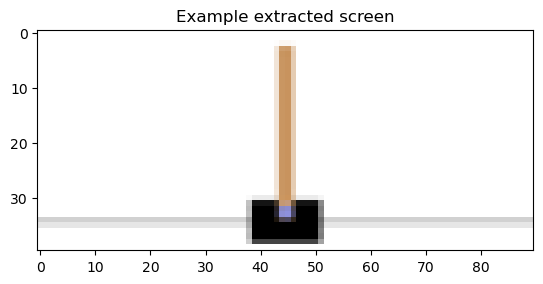

In [4]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # カートの中央

def get_screen():
    # ジムで要求された画面は 400x600x3 だが, 800x1200x3 などもっと大きい場合もある
    # これを torch で用いられる順番 (CHW) に転置 (transpose) する
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    
    # カートは下半分にあるので，画面の上下部分を切り剥がす
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # カートを中心とした正方形の画像を作成するために縁を切り落す
    screen = screen[:, :, slice_range]
    
    # 浮動小数点に変換，再スケール，torch Tensorに変換
    # (これはコピーを必要としない)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    
    # サイズを変更し、バッチディメンションを追加（BCHW）
    return resize(screen).unsqueeze(0)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [6]:
env.render(mode='rgb_array');

# 訓練
<!-- # Training -->

## ハイパーパラメータとユーティリティ
<!-- ## Hyperparameters and utilities-->

このセルはモデルと最適化関数を実体化し，いくつかのユーティリティを定義する:
<!-- This cell instantiates our model and its optimizer, and defines some utilities: -->

- `select_action` - イプシロン貪欲ポリシーに従って行為を選択する。
簡単に言うと，行為を選択するためにモデルを使用することもあれば，一様にサンプリングすることもある。
ランダムな行為を選択する確率は `EPS_START` から始まり，`EPS_END` に向かって指数関数的に減衰していく。
`EPS_DECAY` は減衰の速度を制御する。
- `plot_durations` - エピソードの継続時間を，過去 100 エピソードの平均値 (公式の評価で使用される指標) とともにプロットするためのヘルパー関数。
プロットは，メインの学習反復ループを含むセルの下に表示され，各エピソードの後に更新される。

<!-- - `select_action` - will select an action accordingly to an epsilon greedy policy. 
Simply put, we'll sometimes use our model for choosing the action, and sometimes we'll just sample one uniformly. 
The probability of choosing a random action will start at `EPS_START` and will decay exponentially towards `EPS_END`. 
`EPS_DECAY` controls the rate of the decay.
- `plot_durations` - a helper for plotting the durations of episodes, along with an average over the last 100 episodes (the measure used in the official evaluations). 
The plot will be underneath the cell containing the main training loop, and will update after every episode.
 -->



In [7]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# AI gymから返された形状に基づいて層を正しく初期化できるように，スクリーンサイズを取得する。
# この時点での典型的な寸法は 3x40x90 に近く，これは `get_screen()` 
# でレンダーバッファをクランプしてダウンスケールした結果である。
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Gym の行為空間から行為の数を取得
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) は各行で最大の列の値を返す
            # max の結果の 2 列目は，最大の要素が見つかった場所のインデックス
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    
    # 100 エピソードの平均をとってプロットもする
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # プロットが更新されるように少停止
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

## 学習ループ
<!-- ## Training loop-->

最後に，モデルを学習するコードである。
<!-- Finally, the code for training our model. -->

以下に，最適化の一段階を実行する `optimize_model` 関数がある。
まずバッチをサンプリングし，すべてのテンソルを一つにまとめ，$Q(s_t, a_t)$ と $V(s_{t+1}) = \max_a Q(s_{t+1}, a)$ を計算し，それらを組み合わせて損失を計算する。
定義上，$s$ が終端状態であれば $V(s) = 0$ とする。
また，安定性を高めるために，ターゲットネットワークを使って $V(s_{t+1})$ を計算する。
ターゲットネットワークはその重みがほとんど凍結されたままであるが，ポリシーネットワークの重みで時々更新される。
これは通常決まったステップ数であるが，ここでは簡単のためエピソードとする。
<!-- Here, you can find an `optimize_model` function that performs a single step of the optimization. 
It first samples a batch, concatenates all the tensors into a single one, computes $Q(s_t, a_t)$ and $V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our loss. 
By definition we set $V(s) = 0$ if $s$ is a terminal state. 
We also use a target network to compute $V(s_{t+1})$ for added stability. 
The target network has its weights kept frozen most of the time, but is updated with the policy network's weights every so often.
This is usually a set number of steps but we shall use episodes for simplicity.-->


In [8]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # バッチを転置 (詳しい説明は https://stackoverflow.com/a/19343/3343043 参照)
    # Transitions のバッチ配列からバッチ配列の Transition に変換される
    batch = Transition(*zip(*transitions))

    # 最終状態でないマスクを計算し，そのバッチ要素を連結する
    # (最終状態とは，シミュレーションが終了した後の状態のこと)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Q(s_t, a) を計算する - モデルが Q(s_t) を計算し，次に行われた行動の列を選択する。
    # これらは `policy_net` に従って各バッチの状態に対して取られたであろう行動である
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # すべての次の状態について V(s_{t+1}) を計算する。
    # 最終状態でない次の状態に対する行動の期待値は「古い」target_net に基づいて計算される; 
    # max(1)[0] でその最高の報酬を選択する。
    # これはマスクに基づいてマージされ，状態の期待値か，状態が最終的であった場合には 0 を得る
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    # Q 値の期待値を計算
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Huber 損失を計算
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # モデルの最適化
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

以下に，メイン訓練反復を示す。
最初に環境をリセットし，`state`  テンソルを初期化する。
次に，行動をサンプリングし，実行し，次の画面と報酬 (常に 1) を観察し，モデルを一度最適化する。
エピソードが終了すると (モデルが失敗すると)，ループを再開する。
<!-- Below, you can find the main training loop. 
At the beginning we reset the environment and initialize the `state` Tensor. 
Then, we sample an action, execute it, observe the next screen and the reward (always 1), and optimize our model once. When the episode ends (our model fails), we restart the loop.-->

以下では `num_episodes` は小さく設定されている。
ノートブックをダウンロードし，300以上のエピソードを実行することで，持続時間の改善が期待できる。
<!-- Below, `num_episodes` is set small. You should download the notebook and run lot more epsiodes, such as 300+ for meaningful duration improvements. -->

In [12]:
num_episodes = 50
for i_episode in range(num_episodes):
    
    # 環境と状態を初期化
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    
    for t in count():
        # 選択して実行するアクション
        action = select_action(state)
        _, reward, done, _, _ = env.step(action.item())
        #_, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # 新しい状態を観察
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # 遷移をメモリに格納
        memory.push(state, action, next_state, reward)

        # 次の状態に移動
        state = next_state

        # 最適化の 1 ステップを実行 (ポリシーネットワーク上で)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
            
    # ターゲットネットワークを更新し DQN のすべての重みとバイアスをコピー
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
#env.render()
env.close()
#plt.ioff()
#plt.show()

<Figure size 640x480 with 0 Axes>

Complete


<Figure size 640x480 with 0 Axes>

In [ ]:
#help(env.step)

以下は，結果として得られる全体のデータフローを示す図である。
<!-- Here is the diagram that illustrates the overall resulting data flow. -->

<center>
<img src="https://pytorch.org/tutorials/_images/reinforcement_learning_diagram.jpg" width="66%" alt="reinforcement learning diagram">
</center>
<!-- .. figure:: /_static/img/reinforcement_learning_diagram.jpg -->

行動はランダムに，またはポリシーに基づいて選択され，Gym  環境から次のステップのサンプルを取得する。
その結果をリプレイメモリに記録し，さらに反復毎に最適化ステップを実行する。
最適化では，リプレイメモリからランダムなバッチを選び，新しいポリシーの学習を行う。
また，最適化では  「古い」target_net を使用して Q 値の期待値を計算するため，時々更新して最新の状態を保つ。
<!-- Actions are chosen either randomly or based on a policy, getting the next step sample from the gym environment. 
We record the results in the replay memory and also run optimization step on every iteration.
Optimization picks a random batch from the replay memory to do training of the new policy. 
"Older" target_net is also used in optimization to compute the expected Q values; it is updated occasionally to keep it current. -->

